In [ ]:
import cmaps
import numpy as np
import scipy.signal as signal
import matplotlib.pyplot as plt
import netCDF4 as nc
import os
import xarray as xr
import glob
import sys
import pickle
import datetime
import pandas as pd
import calendar
import cartopy.crs as ccrs
import matplotlib.ticker as mticker
import matplotlib.ticker as ticker
import cartopy.feature as cfeature
from matplotlib.colors import LinearSegmentedColormap
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

读取数据

In [3]:

_path_  = r"/Users/xpji/Wave_trend/olr.day.mean.nc"
ds = xr.open_dataset(_path_).olr.sel(lat=slice(25,-25),time=slice('1975-01-01','2022-12-31')).sortby('lat')
ds
ds_clm = ds.groupby('time.dayofyear').mean('time')

# ds_clm = signal.detrend(ds_clm,axis=0,type='linear')
ds_clm



<xarray.DataArray 'olr' (dayofyear: 366, lat: 21, lon: 144)>
array([[[266.9554 , 267.87415, 267.5879 , ..., 266.2852 , 265.8281 ,
         266.56372],
        [268.2179 , 266.53152, 267.3754 , ..., 268.08017, 268.31912,
         267.88342],
        [266.68478, 266.01663, 266.3429 , ..., 267.45706, 267.1558 ,
         267.21872],
        ...,
        [251.46144, 252.19104, 255.64143, ..., 245.46832, 245.18665,
         249.7729 ],
        [250.99269, 254.38664, 252.83789, ..., 253.50185, 253.95892,
         252.86078],
        [257.9833 , 262.48935, 253.53102, ..., 254.92686, 260.12976,
         255.28624]],

       [[266.32312, 266.34103, 266.64395, ..., 267.0475 , 266.4998 ,
         266.45084],
        [266.79916, 265.94058, 266.66687, ..., 268.29907, 267.56332,
         267.74222],
        [264.95834, 266.096  , 265.71436, ..., 269.4127 , 269.21017,
         267.82874],
...
        [256.16467, 256.64893, 259.15512, ..., 247.47511, 246.94957,
         250.03021],
        [256.23746, 255.6108 , 253.29297, ..., 252.3602 , 253.06935,
         256.23187],
        [255.77126, 262.49612, 254.17465, ..., 252.62085, 253.02745,
         252.38638]],

       [[266.86917, 267.24417, 267.3633 , ..., 269.84164, 267.9233 ,
         265.55334],
        [267.43167, 266.01834, 266.89   , ..., 269.20667, 266.63834,
         267.66418],
        [268.30502, 266.74332, 267.86084, ..., 267.76166, 267.76   ,
         268.98083],
        ...,
        [253.30168, 250.9575 , 252.24   , ..., 247.11168, 251.62917,
         253.91583],
        [244.995  , 249.0675 , 250.67249, ..., 247.17665, 249.07251,
         251.005  ],
        [245.50916, 253.11665, 244.79665, ..., 250.54333, 250.88167,
         249.34666]]], dtype=float32)
Coordinates:
  * lon        (lon) float32 0.0 2.5 5.0 7.5 10.0 ... 350.0 352.5 355.0 357.5
  * lat        (lat) float32 -25.0 -22.5 -20.0 -17.5 ... 17.5 20.0 22.5 25.0
  * dayofyear  (dayofyear) int64 1 2 3 4 5 6 7 8 ... 360 361 362 363 364 365 366
Attributes:
    units:         W/m^2
    var_desc:      Outgoing Longwave Radiation
    precision:     2
    dataset:       NOAA Interpolated OLR
    level_desc:    Other
    statistic:     Mean
    parent_stat:   Individual Obs
    valid_range:   [  0. 500.]
    long_name:     Daily Mean OLR
    actual_range:  [ 64.75 344.5 ]

getvardimws


reorder make time fastest varying dimension

In [4]:

z = ds_clm.transpose('lat', 'lon','dayofyear')



In [5]:
z.shape

(21, 144, 366)

进行傅里叶变化
- np.fft.fft() 快速傅里叶变换 这个函数使用有效离散傅里叶变换(FFT)算法计算一维 n 点快速傅里叶变换(dFT)。
- np.fft.rfft() 计算实际输入的一维离散傅里叶变换。这个函数通过一个叫做离散傅里叶变换(FFT)的高效算法计算一个实值数组的一维 n 点快速傅里叶变换(dFT)。

| 特点       | `np.fft.fft`           | `np.fft.rfft`                                      |
|------------|------------------------|----------------------------------------------------|
| 输入类型   | 复数或实数             | 仅实数                                             |
| 输出长度   | 与输入长度相同         | `(n//2)+1`        ，只有一半                                 |
| 输出内容   | 包含正负频率成分       | 包含直流分量、正频率分量和 Nyquist 频率分量       |
| 计算量     | 相对较大               | 相对较小                                           |

In [6]:
z_fft = np.fft.fft(z, axis=-1)
f = np.fft.fftfreq(z.shape[-1])
print(1/f[1:])
z_fft.shape
nHarm = 2
z_fft[:, :, nHarm] *= 0.5  # 缩小指定谐波的系数
z_fft[:, :, nHarm + 1:] = 0  # 设置高阶谐波为 0

z_reconstructed = np.fft.ifft(z_fft, axis=-1).real  # 保留实数部分
z_reconstructed.shape

[ 366.          183.          122.           91.5          73.2
   61.           52.28571429   45.75         40.66666667   36.6
   33.27272727   30.5          28.15384615   26.14285714   24.4
   22.875        21.52941176   20.33333333   19.26315789   18.3
   17.42857143   16.63636364   15.91304348   15.25         14.64
   14.07692308   13.55555556   13.07142857   12.62068966   12.2
   11.80645161   11.4375       11.09090909   10.76470588   10.45714286
   10.16666667    9.89189189    9.63157895    9.38461538    9.15
    8.92682927    8.71428571    8.51162791    8.31818182    8.13333333
    7.95652174    7.78723404    7.625         7.46938776    7.32
    7.17647059    7.03846154    6.90566038    6.77777778    6.65454545
    6.53571429    6.42105263    6.31034483    6.20338983    6.1
    6.            5.90322581    5.80952381    5.71875       5.63076923
    5.54545455    5.46268657    5.38235294    5.30434783    5.22857143
    5.15492958    5.08333333    5.01369863    4.94594595    4.88
 

(21, 144, 366)

In [7]:
z_fft[:,:,1]

array([[  793.98185383-1302.66827498j,   734.64347334-1227.86657725j,
          646.96883612-1182.75197188j, ...,
          844.86230659-1452.64616032j,   839.5212742 -1433.84266193j,
          807.76549808-1373.9821743j ],
       [  577.04452908-1221.68662595j,   508.32841725-1181.85323752j,
          381.49424354-1159.2517731j , ...,
          576.07027099-1366.25299043j,   597.44630143-1331.31999911j,
          593.59480079-1280.9743781j ],
       [  377.4728794 -1193.72244256j,   288.45101719-1184.15661192j,
          121.17824854-1180.31593985j, ...,
          397.48801735-1248.52800339j,   422.46917958-1238.8542015j ,
          412.02146496-1206.9144616j ],
       ...,
       [-2166.57167016 -171.87905136j, -2611.7853755  +135.80699855j,
        -3056.67220123 +523.63826466j, ...,
        -3919.28547115 -102.156055j  , -3706.58671238  +43.56299249j,
        -2971.23002293  -38.62316942j],
       [-3814.25673324 +524.59132736j, -3629.24608652 +568.90707889j,
        -3521.67474615

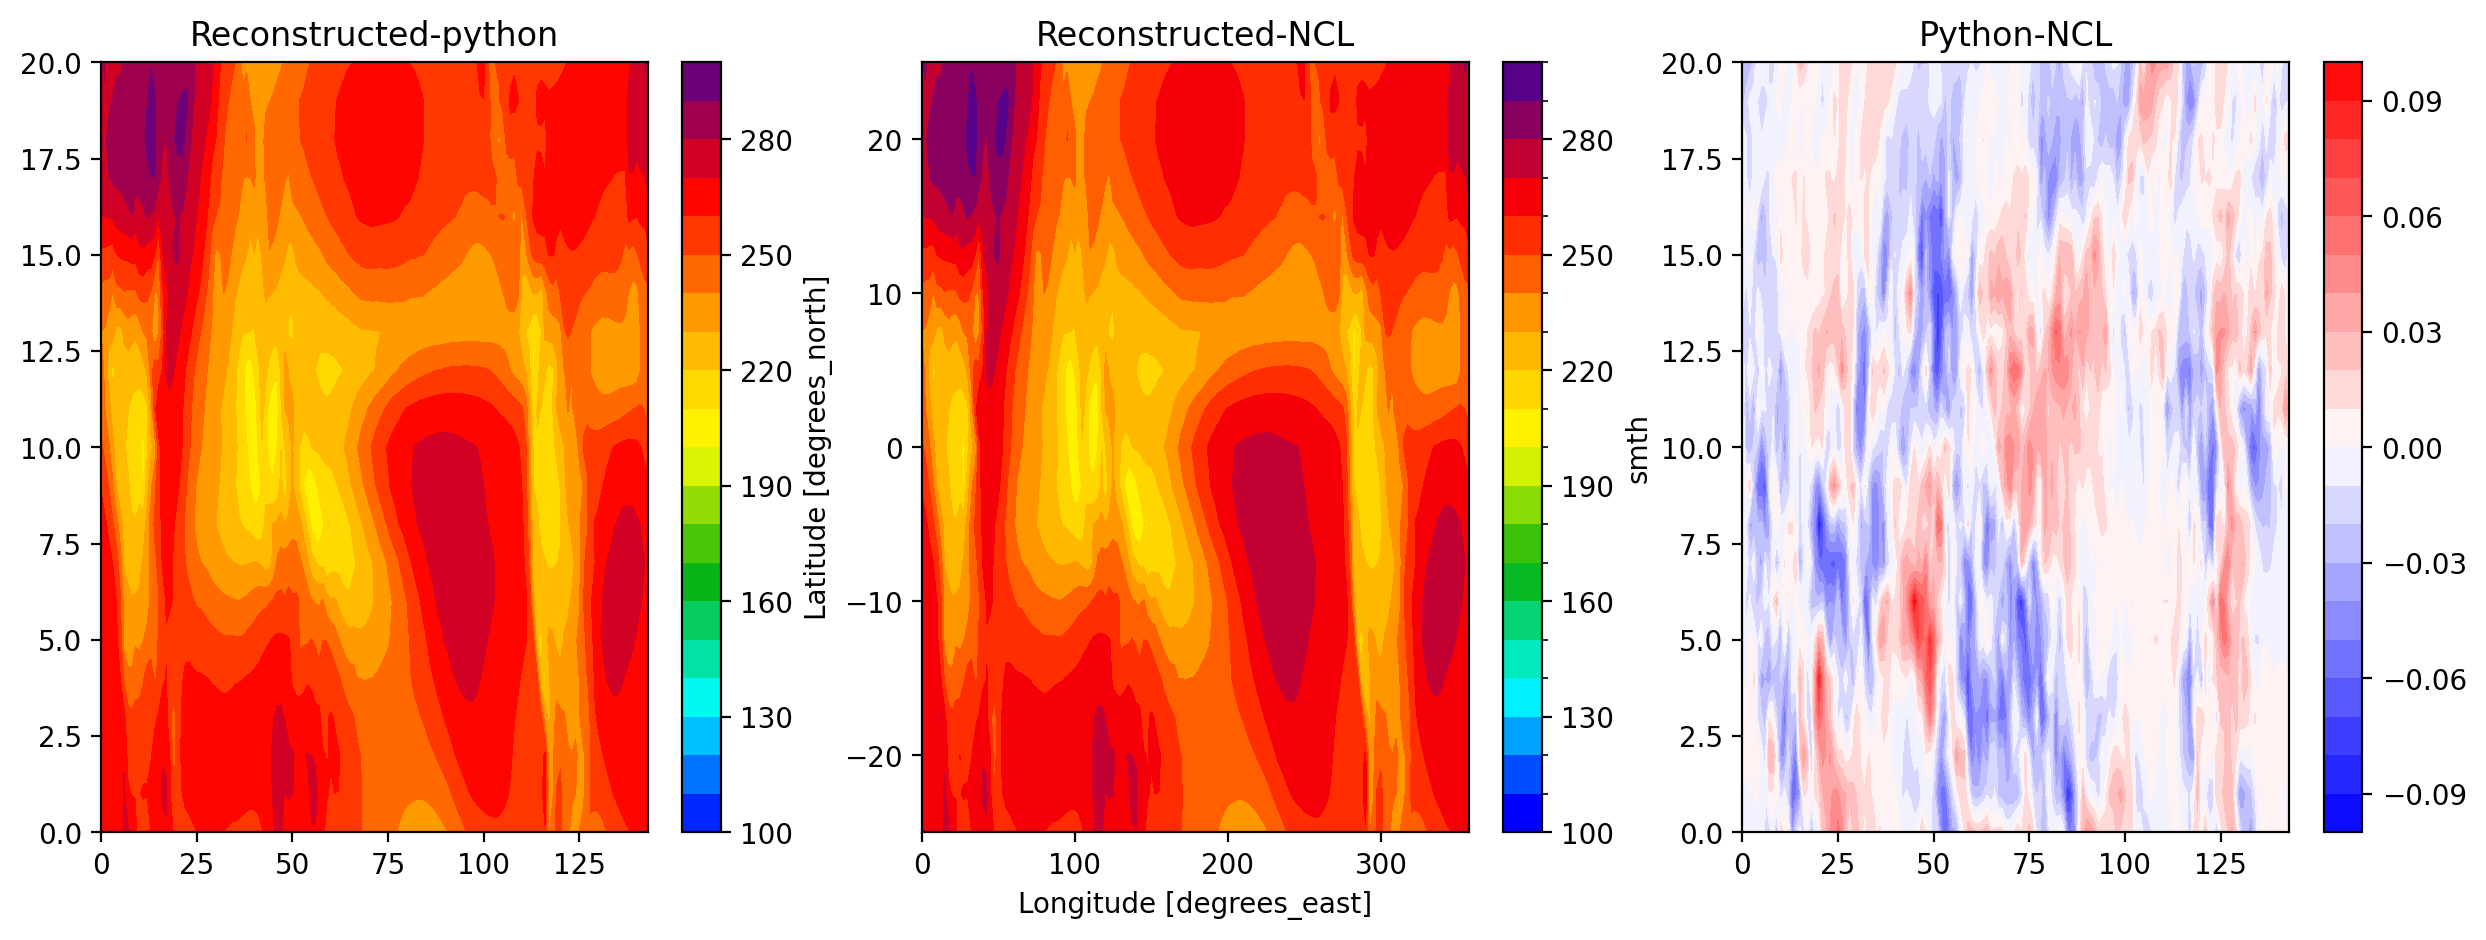

In [21]:
plt.figure(dpi=200,figsize=(15,5))
plt.subplot(131)
cb = plt.contourf(np.nanmean(z_reconstructed,axis=2),levels=np.linspace(100,300,21),cmap=cmaps.BlAqGrYeOrReVi200)
plt.colorbar(cb)
plt.title('Reconstructed-python')
plt.subplot(132)
dd = xr.open_dataset("/Users/xpji/Wave_trend/smth2.nc")
dd.smth.mean('year_day').plot.contourf(levels=np.linspace(100,300,21),cmap=cmaps.BlAqGrYeOrReVi200)
plt.title('Reconstructed-NCL')
plt.subplot(133)
cb = plt.contourf(np.nanmean(z_reconstructed,axis=2)-dd.smth.mean('year_day').values,cmap='bwr',levels=21)
plt.title('Python-NCL')
plt.colorbar(cb)

ezfftf：对一个真正的周期性序列执行傅立叶变换家族中的关系。